# 2D Advection-Diffusion equation

in this notebook we provide a simple example of the DeepMoD algorithm and apply it on the 2D advection-diffusion equation. 

In [36]:
# General imports
import numpy as np
import torch
import matplotlib.pylab as plt

# DeepMoD functions

from deepymod import DeepMoD
from deepymod.model.func_approx import NN
from deepymod.model.library import Library2D
from deepymod.model.constraint import LeastSquares
from deepymod.model.sparse_estimators import Threshold,PDEFIND
from deepymod.training import train
from deepymod.training.sparsity_scheduler import TrainTestPeriodic
from scipy.io import loadmat

# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Prepare the data

Next, we prepare the dataset.

In [37]:
data = loadmat('advection_diffusion.mat')
usol = np.real(data['Expression1'])
usol= usol.reshape((51,51,61,4))

x_v= usol[:,:,:,0]
y_v = usol[:,:,:,1]
t_v = usol[:,:,:,2]
u_v = usol[:,:,:,3]

Next we plot the dataset for three different time-points

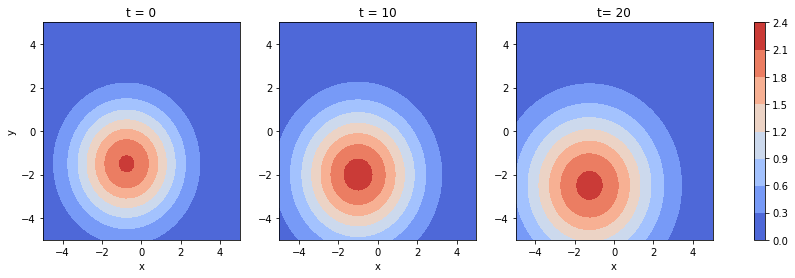

In [38]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))

im0 = axes[0].contourf(x_v[:,:,0], y_v[:,:,0], u_v[:,:,0], cmap='coolwarm')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('t = 0')

im1 = axes[1].contourf(x_v[:,:,10], y_v[:,:,10], u_v[:,:,10], cmap='coolwarm')
axes[1].set_xlabel('x')
axes[1].set_title('t = 10')

im2 = axes[2].contourf(x_v[:,:,20], y_v[:,:,20], u_v[:,:,20], cmap='coolwarm')
axes[2].set_xlabel('x')
axes[2].set_title('t= 20')

fig.colorbar(im1, ax=axes.ravel().tolist())

plt.show()

We flatten it to give it the right dimensions for feeding it to the network:

In [39]:
X = np.transpose((t_v.flatten(),x_v.flatten(), y_v.flatten()))
y = np.float32(u_v.reshape((u_v.size, 1)))

We select the noise level we add to the data-set

In [40]:
noise_level = 0.025

In [41]:
y_noisy = y + noise_level * np.std(y) * np.random.randn(y.size, 1)

Select the number of samples:

In [42]:
number_of_samples = 5000

idx = np.random.permutation(y.shape[0])
X_train = torch.tensor(X[idx, :][:number_of_samples], dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y_noisy[idx, :][:number_of_samples], dtype=torch.float32)



# Define differentiation method 

In [8]:
import pysindy as ps

In [9]:
fd_spline = ps.SINDyDerivative(kind='spline', s=1e-2)
fd_spectral = ps.SINDyDerivative(kind='spectral')
fd_sg = ps.SINDyDerivative(kind='savitzky_golay', left=0.5, right=0.5, order=3)

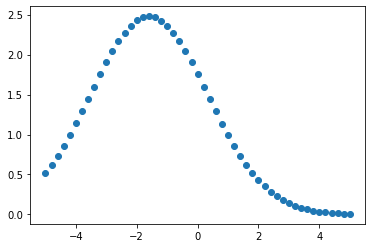

In [10]:
y = u_v[25,:,2]
x = y_v[25,:,2]
plt.scatter(x,y)

In [11]:
y.shape

(51,)

In [12]:
noise_level = 0.025
y_noisy = y + noise_level * np.std(y) * np.random.randn(y.size)

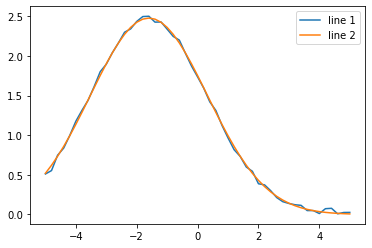

In [13]:
ax = plt.subplot(1,1,1)
ax.plot(x,y_noisy, label="line 1")
ax.plot(x,y, label="line 2")
ax.legend()

## Configuration of DeepMoD

Configuration of the function approximator: Here the first argument is the number of input and the last argument the number of output layers.

In [14]:
network = NN(3, [50, 50, 50,50], 1)

Configuration of the library function: We select athe library with a 2D spatial input. Note that that the max differential order has been pre-determined here out of convinience. So, for poly_order 1 the library contains the following 12 terms:
* [$1, u_x, u_y, u_{xx}, u_{yy}, u_{xy}, u, u u_x, u u_y, u u_{xx}, u u_{yy}, u u_{xy}$]

In [15]:
library = Library2D(poly_order=1) 

Configuration of the sparsity estimator and sparsity scheduler used. In this case we use the most basic threshold-based Lasso estimator and a scheduler that asseses the validation loss after a given patience. If that value is smaller than 1e-5, the algorithm is converged.  

In [16]:
estimator = Threshold(0.1) 
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=10, delta=1e-5) 

Configuration of the sparsity estimator 

In [17]:
constraint = LeastSquares() 
# Configuration of the sparsity scheduler

Now we instantiate the model and select the optimizer 

In [18]:
model = DeepMoD(network, library, estimator, constraint)

# Defining optimizer
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=1e-3) 


## Run DeepMoD 

We can now run DeepMoD using all the options we have set and the training data:
* The directory where the tensorboard file is written (log_dir)
* The ratio of train/test set used (split)
* The maximum number of iterations performed (max_iterations)
* The absolute change in L1 norm considered converged (delta)
* The amount of epochs over which the absolute change in L1 norm is calculated (patience)

In [19]:
train(model, X_train, y_train, optimizer,sparsity_scheduler, log_dir='runs/2DAD_new/', split=0.8, max_iterations=100000, delta=1e-6, patience=25) 

  2550  MSE: 3.31e-04  Reg: 1.62e-04  L1: 1.98e+00 

KeyboardInterrupt: 

Sparsity masks provide the active and non-active terms in the PDE:

In [20]:
model.sparsity_masks

[tensor([ True,  True,  True,  True,  True, False,  True, False, False, False,
         False, False])]

estimatior_coeffs gives the magnitude of the active terms:

In [21]:
print(model.estimator_coeffs())

[array([[ 0.11376898],
       [ 0.37273598],
       [ 0.6882936 ],
       [ 0.30466506],
       [ 0.22289614],
       [ 0.        ],
       [-0.21975559],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]], dtype=float32)]


In [22]:
sol = model(torch.tensor(X, dtype=torch.float32))[0].reshape((51,51,61)).detach().numpy()

In [23]:
ux = model(torch.tensor(X, dtype=torch.float32))[2][0][:,1].reshape((51,51,61)).detach().numpy()

In [24]:
uy = model(torch.tensor(X, dtype=torch.float32))[2][0][:,2].reshape((51,51,61)).detach().numpy()

In [25]:
uyy = model(torch.tensor(X, dtype=torch.float32))[2][0][:,4].reshape((51,51,61)).detach().numpy()

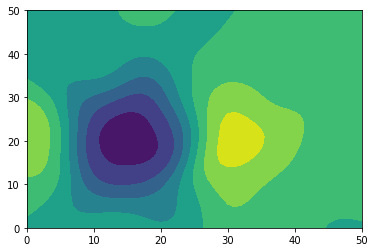

In [26]:
plt.contourf(uyy[:,:,10])

In [27]:
import pysindy as ps

In [28]:
fd_spline = ps.SINDyDerivative(kind='spline', s=1e-2)
fd_spectral = ps.SINDyDerivative(kind='spectral')
fd_smooth = ps.differentiation.SmoothedFiniteDifference()

In [29]:
fd_sg = ps.SINDyDerivative(kind='savitzky_golay', left=0.5, right=0.5, order=3)

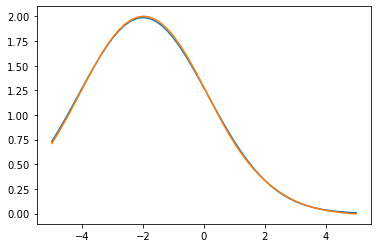

In [30]:
y = u_v[25,:,10]
x = y_v[25,:,10]
plt.plot(x,y)
plt.plot(x,sol[25,:,10])

In [31]:
noise_level = 0.025
y_noisy = y + noise_level * np.std(y) * np.random.randn(y.size)

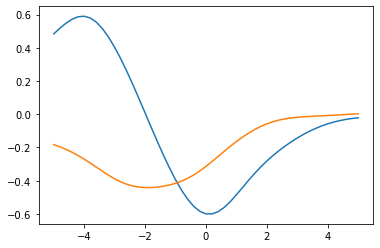

In [32]:
plt.plot(x,uy[25,:,10])
plt.plot(x,ux[25,:,10])

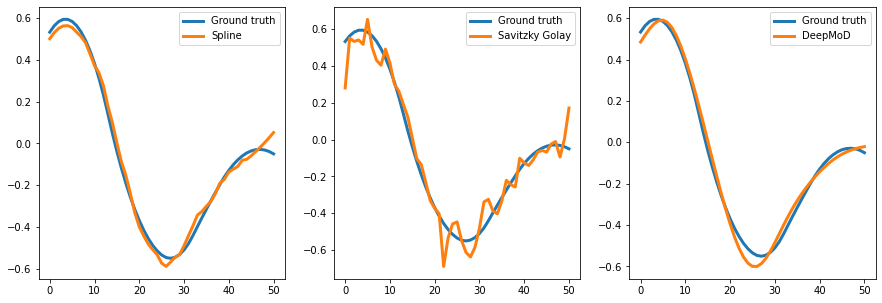

In [35]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,3, 1)
plt.plot(fd_spline(y.reshape(-1,1),x), label='Ground truth',linewidth=3)
plt.plot(fd_smooth(y_noisy.reshape(-1,1),x), label='Spline',linewidth=3)
plt.legend()

plt.subplot(1,3, 2)
plt.plot(fd_spline(y.reshape(-1,1),x), label='Ground truth',linewidth=3)
plt.plot(fd_sg(y_noisy.reshape(-1,1),x), label='Savitzky Golay',linewidth=3)
plt.legend()

plt.subplot(1,3, 3)
plt.plot(fd_spline(y.reshape(-1,1),x), label='Ground truth',linewidth=3)
plt.plot(uy[25,:,10],linewidth=3, label='DeepMoD')
plt.legend()

plt.show()

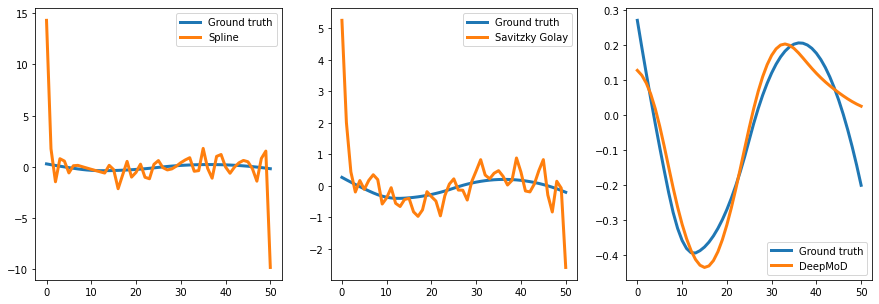

In [30]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,3, 1)
plt.plot(fd_spline(fd_spline(y.reshape(-1,1),x),x), label='Ground truth',linewidth=3)
plt.plot(fd_spline(fd_spline(y_noisy.reshape(-1,1),x),x), label='Spline',linewidth=3)
plt.legend()

plt.subplot(1,3, 2)
plt.plot(fd_spline(fd_spline(y.reshape(-1,1),x),x), label='Ground truth',linewidth=3)
plt.plot(fd_sg(fd_sg(y_noisy.reshape(-1,1),x),x), label='Savitzky Golay',linewidth=3)
plt.legend()

plt.subplot(1,3, 3)
plt.plot(fd_spline(fd_spline(y.reshape(-1,1),x),x), label='Ground truth',linewidth=3)
plt.plot(uyy[25,:,10],linewidth=3, label='DeepMoD')
plt.legend()

plt.show()